<a href="https://colab.research.google.com/github/yagiyuki/axross/blob/main/Permutation_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Permutation Importanceを活用した特徴量の重要度評価のレシピ

## レシピの概要

このレシピでは、機械学習における特徴量の重要度評価手法として、Permutation Importanceを紹介します。

機械学習の特徴量の重要度評価は、Feature Importanceによるものが有名です。   
<Google Trend 図>
しかし、Permutation ImportanceにはFeature Importanceには無い利点があります。

このレシピでは、Feature Importanceとの比較をしつつ、  Permutation Importanceによる特徴量の重要度評価を学んでいきます。

## 前提知識
* python (基本構文であるif, for などが理解できる。)
* sklearn, pandasなどのライブラリを扱える(写経できる)
* 機械学習の教師あり学習の概念がわかる

## 学べること

* "Feature Importance"と"Permutation Importance"による特徴量の重要度評価・可視化の方法
* "Permutation Importance"を活用した精度改善の方法


## 材料・道具

### 実行環境
Google Colaboratory

### 道具
* python
* pandas
* matplotlib
* seaborn
* numpy
* scipy
* sklearn

## 材料
学習・評価データとして、タイタニック号のデータを使います。  
https://github.com/mwaskom/seaborn-data/blob/master/titanic.csv

## 必要なモジュールのImport

In [16]:
# 必要モジュールのImport
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

## データの取得・前処理

評価に使うタイタニック号のデータの取得と前処理をします。

In [17]:
# タイタニックのデータ号のデータ取得
df = sns.load_dataset('titanic')
# 上位3件
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


info関数でデータを詳細に見るといくつか問題点があることがわかります。

* 数値以外の情報がある (sex, embarked, classなど)
* 欠損値がある (ege, fareなど)


In [19]:
df = df.drop(['who', 'adult_male', 'embark_town', 'alive', 'alone'], axis=1)
#df = df.drop(['who', 'embark_town', 'alive'], axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   survived  891 non-null    int64   
 1   pclass    891 non-null    int64   
 2   sex       891 non-null    object  
 3   age       714 non-null    float64 
 4   sibsp     891 non-null    int64   
 5   parch     891 non-null    int64   
 6   fare      891 non-null    float64 
 7   embarked  889 non-null    object  
 8   class     891 non-null    category
 9   deck      203 non-null    category
dtypes: category(2), float64(2), int64(4), object(2)
memory usage: 58.0+ KB


In [21]:
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck
0,0,3,male,22.0,1,0,7.2500,S,Third,NaN
1,1,1,female,38.0,1,0,71.2833,C,First,C
2,1,3,female,26.0,0,0,7.9250,S,Third,NaN


In [22]:
# 文字列形式のデータを数値に置き換え
encode_cols = ['sex', 'embarked', 'class', 'deck']
lbl = LabelEncoder()
for f in encode_cols:
    df[f] = lbl.fit_transform(list(df[f].values))

In [23]:
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck
0,0,3,1,22.0,1,0,7.2500,2,2,7
1,1,1,0,38.0,1,0,71.2833,0,0,2
2,1,3,0,26.0,0,0,7.9250,2,2,7


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    int64  
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  891 non-null    int64  
 8   class     891 non-null    int64  
 9   deck      891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


In [25]:
# 数値系データの欠損値を平均値で補完
encode_cols = ['age']

for f in encode_cols:
    df[f].fillna(df[f].mean(), inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    int64  
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  891 non-null    int64  
 8   class     891 non-null    int64  
 9   deck      891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


In [27]:
# 生存を予測するモデルを作るので、特徴量は['survived']を外したものとする
X = df.drop(['survived'], axis=1)
# 目的変数はsurvivedとする。
y = df['survived'].values

In [28]:
# 学習データ: テストデータ=7:3で分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [29]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
#np.savetxt('y_train.txt', y_train)
#np.savetxt('y_test.txt', y_test)

In [30]:
#X_train = pd.read_csv('X_train.csv')
#X_test = pd.read_csv('X_test.csv')
#y_train = np.loadtxt('y_train.txt', np.int32)
#y_test = np.loadtxt('y_test.txt', np.int32)

In [31]:
X_train.head(3)

,pclass,sex,age,sibsp,parch,fare,embarked,class,deck
748,1,1,19.000000,1,0,53.1000,2,0,3
45,3,1,29.699118,0,0,8.0500,2,2,7
28,3,0,29.699118,0,0,7.8792,1,2,7


## ランダムフォレストで学習


In [32]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)

In [33]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred[:10])
print(accuracy_score(y_test, y_pred))

[0 0 0 0 0 0 0 1 0 1]
0.8059701492537313


## Feature Importanceによる評価

Permutation Importanceとの比較のためFeature Importanceによる特徴量の評価をします。  

Feature Importanceは、各特徴量の分類寄与率を評価する指標です。  
もう少し詳しくいうと、「ある特徴量で分割することでどれくらいジニ不純度を下げられるのか」ということになります。  
木構造のアルゴリズムの特性を生かした評価指標になります。




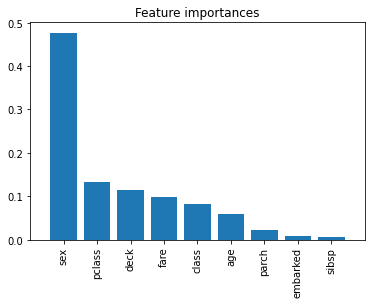

In [34]:
# Feature Importanceによる重要度の可視化
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.show()

In [35]:
print(sum(clf.feature_importances_))

1.0


## Permutation Importanceによる評価

本題である、Permutation Importanceでの評価をします。 
Permutation Importanceは、「ある特徴量がどれだけモデルの予測精度向上に寄与しているのか」を評価する手法です。  
評価方法は非常にシンプルで、評価対象の特徴量をランダムに並べ替え、
予測精度にどのくらい影響を出すかを評価します。
(精度が低下が大きいほど予測に重要な特徴量といえる)

Permutation Importanceは、Feature Importanceの以下と比較して以下のメリットがあります。
* 木構造のアルゴリズム以外で使える
* 学習データとテストデータの両方に対して評価できる(Feature Importanceは、学習データを基準とした評価となる)
* 特徴量の算出方法が直感的

### 学習データに対するpermutation

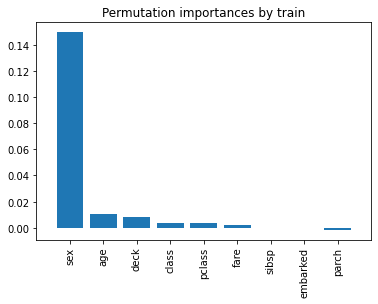

In [36]:
# 重要度をpermutation_importanceに変更する。
permutation_result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=0)
importances = permutation_result.importances_mean

indices = np.argsort(importances)[::-1]

fig = plt.figure()
plt.title("Permutation importances by train") # タイトルをかえる
plt.bar(range(X_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.show()


### テストデータに対するpermutation

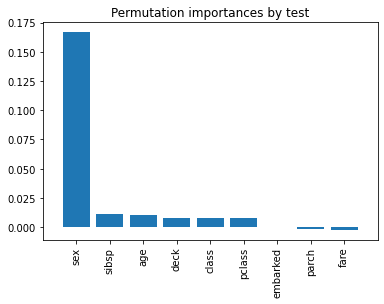

In [37]:
# 重要度をpermutation_importanceに変更する。また、評価対象はテストデータとする。
permutation_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)
importances = permutation_result.importances_mean

indices = np.argsort(importances)[::-1]
plt.figure()
# タイトルをかえる
plt.title("Permutation importances by test")
plt.bar(range(X_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.show()

## 特徴量の削減

In [38]:
drop_list = ["fare"]
X_train_2 = X_train.drop(drop_list, axis=1)
X_test_2 = X_test.drop(drop_list, axis=1)

In [39]:
clf.fit(X_train_2, y_train)
y_pred = clf.predict(X_test_2)
accuracy_score(y_test, y_pred)

0.8097014925373134

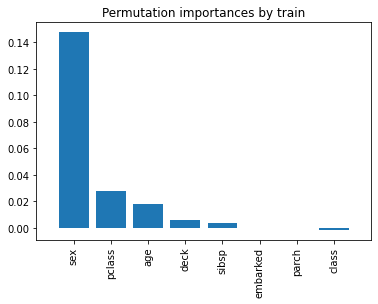

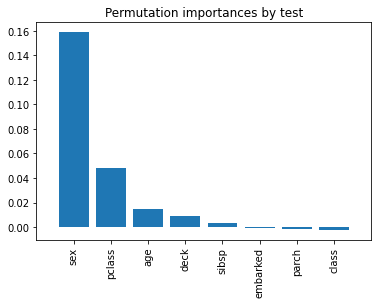

In [40]:

""" 学習データに対する評価 """
permutation_result = permutation_importance(clf, X_train_2, y_train, n_repeats=10, random_state=0)
importances = permutation_result.importances_mean
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Permutation importances by train")
plt.bar(range(X_test_2.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test_2.shape[1]), X_test_2.columns[indices], rotation='vertical')
plt.xlim([-1, X_test_2.shape[1]])

""" テストデータに対する評価 """
permutation_result = permutation_importance(clf, X_test_2, y_test, n_repeats=10,
                                random_state=0)
importances = permutation_result.importances_mean
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Permutation importances by test")
plt.bar(range(X_test_2.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test_2.shape[1]), X_test_2.columns[indices], rotation='vertical')
plt.xlim([-1, X_test_2.shape[1]])
plt.show()